In [1]:
%load_ext autoreload
%load_ext memory_profiler
%autoreload 2
from bp import parse_newick, to_skbio_treenode, to_skbio_treearray
from skbio import TreeNode
import numpy as np
import glob
from functools import partial
import time
from random import shuffle
%matplotlib notebook
import matplotlib.pyplot as plt

In [2]:
def _correct_gg_reroot_length_issue(t):
    # the greengenes trees on reroot had a node with a length set to None
    # find and correct if it exists
    try:
        gg_reroot_none_node = t.find('k__Bacteria')
        gg_reroot_none_node.length = 0.0
    except:
        pass

    return t

def shear_names(skt):
    # determine which tips to keep
    names = [n.name for n in skt.tips()]
    shuffle(names)
    to_keep = int(np.ceil(len(names) * 0.1))
    names_to_keep = set(names[:to_keep])
    return names_to_keep

def read_before_parse_newick(f):
    """we need to have newick in memory right now, so not a fair comparison if we cache"""
    return parse_newick(open(f).read())

In [3]:
results = {'timings': {}, 'memories': {}}

start = time.time()
for f in glob.glob('../../../greengenes_release/gg_13_8_otus/trees/*_otus.tree'):
    obs_t = {}
    obs_m = {}
    key = f.rsplit('/')[-1]
    #if key.startswith('9'):# or key.startswith('8') or key.startswith('7'):
     #   continue
    print(key)
    
    # load trees for non-parse tests
    sktree = TreeNode.read(f)
    bptree = parse_newick(open(f).read())
    
    # parse timings and memory
    sk_parse_t = %timeit -o -q TreeNode.read(f)
    sk_parse_m = %memit -o -q TreeNode.read(f)
    bp_parse_t = %timeit -o -q read_before_parse_newick(f)
    bp_parse_m = %memit -o -q read_before_parse_newick(f)
    
    shear_names_to_keep = shear_names(sktree)
    
    # shear times and memory
    sk_shear_t = %timeit -o -q sktree.shear(shear_names_to_keep)
    sk_shear_m = %memit -o -q sktree.shear(shear_names_to_keep)
    bp_shear_t = %timeit -o -q bptree.shear(shear_names_to_keep)
    bp_shear_m = %memit -o -q bptree.shear(shear_names_to_keep)

    # to_array times and memory
    sk_toarray_t = %timeit -o -q sktree.to_array()
    sk_toarray_m = %memit -o -q sktree.to_array()
    bp_toarray_t = %timeit -o -q to_skbio_treearray(bptree)
    bp_toarray_m = %memit -o -q to_skbio_treearray(bptree)
    
    obs_t['n_tips'] = bptree.ntips()
    obs_t['sk_parse'] = sk_parse_t
    obs_t['bp_parse'] = bp_parse_t
    obs_t['sk_shear'] = sk_shear_t
    obs_t['bp_shear'] = bp_shear_t
    obs_t['sk_toarray'] = sk_toarray_t
    obs_t['bp_toarray'] = bp_toarray_t
    results['timings'][key] = obs_t
    
    obs_m['n_tips'] = bptree.ntips()
    obs_m['sk_parse'] = sk_parse_m
    obs_m['bp_parse'] = bp_parse_m
    obs_m['sk_shear'] = sk_shear_m
    obs_m['bp_shear'] = bp_shear_m
    obs_m['sk_toarray'] = sk_toarray_m
    obs_m['bp_toarray'] = bp_toarray_m    
    results['memories'][key] = obs_m
    
print("Bench walltime: %0.2fs" % (time.time() - start))

61_otus.tree
64_otus.tree
67_otus.tree
70_otus.tree
73_otus.tree
76_otus.tree
79_otus.tree
82_otus.tree
85_otus.tree
88_otus.tree
91_otus.tree
94_otus.tree
97_otus.tree
99_otus.tree


TypeError: unsupported operand type(s) for -: 'str' and 'float'

<IPython.core.display.Javascript object>


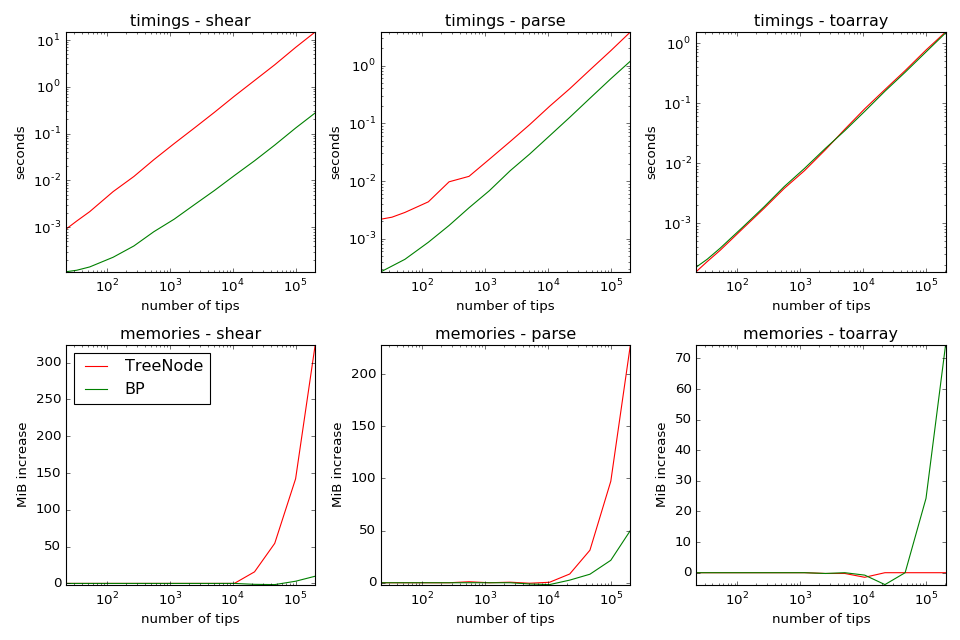

In [7]:
order = [f.rsplit('/')[-1] for f in glob.glob('../../../greengenes_release/gg_13_8_otus/trees/*_otus.tree')]
order = [o for o in order if o in results['timings']]
xaxis = [results['timings'][o]['n_tips'] for o in order]

time_getter = lambda x: x.best
mem_getter = lambda x: max(x.mem_usage) - x.baseline

fig, grid = plt.subplots(2, 3, figsize=(12, 8))
for row, (bench_type, getter) in enumerate([('timings', time_getter), ('memories', mem_getter)]):
    for col, plot in enumerate(['shear', 'parse', 'toarray']):
        sktimes = []
        bptimes = []

        for o in order:
            sktimes.append(getter(results[bench_type][o]['sk_%s' % plot]))
            bptimes.append(getter(results[bench_type][o]['bp_%s' % plot]))

        ax = grid[row, col]
        ax.plot(xaxis, sktimes, 'r')
        ax.plot(xaxis, bptimes, 'g')
        ax.set_title("%s - %s" % (bench_type, plot))
        ax.set_xlim(min(xaxis), max(xaxis))
        ax.set_ylim(min(min(sktimes), min(bptimes)), max(max(sktimes), max(bptimes)))
        if bench_type == 'timings':
            ax.set_yscale('log')
        ax.set_xscale('log')
        ax.set_xlabel('number of tips')
        ax.set_ylabel('seconds' if bench_type == 'timings' else 'MiB increase')
grid[1,0].legend(['TreeNode', 'BP'], loc=0)
fig.tight_layout()

In [ ]:
from bp import parse_newick, to_skbio_treenode, to_skbio_treearray

fp = '../../../greengenes_release/gg_13_8_otus/trees/99_otus.tree'
bpt = parse_newick(open(fp).read())
stats = %prun -r to_skbio_treearray(bpt)

In [ ]:
stats.sort_stats('tot').strip_dirs().print_stats()

In [ ]:
bpt.B.sum()

In [5]:
print("Bench walltime: %0.2fs" % (time.time() - start))

Bench walltime: 876.92s
